# surface lenght

In [1]:
import skfmm
from scipy.ndimage import distance_transform_edt
from scipy.signal import convolve2d
from main import *

from glob import glob

import seaborn as sns

import pandas as pd

from tqdm import tqdm

import os
import string

In [2]:
folder = 'sulov_folder'
files = glob(folder + '/BIN-*points.tif')
files

names = [os.path.basename(f)[:-11] for f in files]
names

n = len(names)

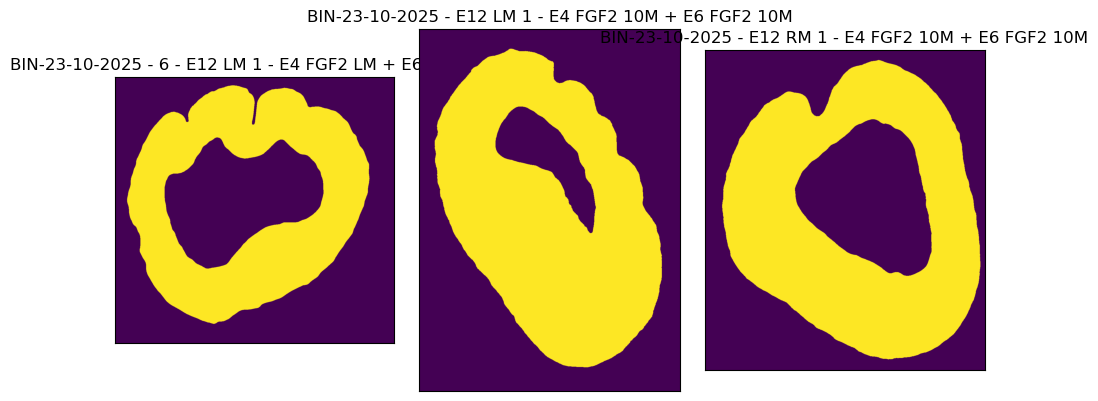

In [3]:
fig, axs = plt.subplots(1, n, figsize = (3*n,4))

for i, name in enumerate(names):

    donut, res = get_picture2D(f'{folder}/{name}.tif')

    axs[i].set_title(name)
    axs[i].imshow(donut)


for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()


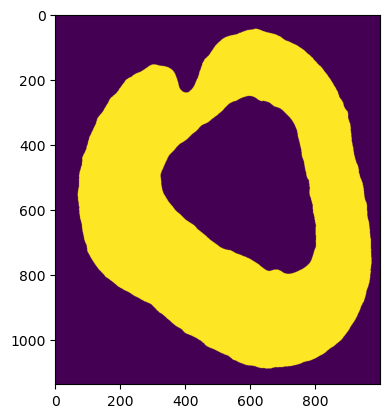

In [4]:
donut, res = get_picture2D(f'{folder}/{names[2]}.tif')

plt.imshow(donut)

donut = np.pad(donut, pad_width=10, mode='constant', constant_values=0)

plt.imshow(donut)


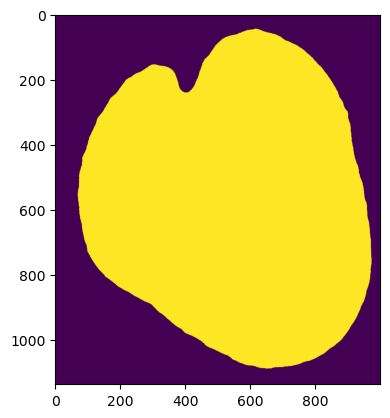

In [5]:
# donut = smoothing(donut, 10)

donut_mask = donut != 0

# we should have only ventricle and outside regions
labeled, n = label(~ donut_mask)

if n != 2:
    raise ValueError('problem with masks, too many regions')

# outside label is the label of the pixel on the top left
outside_label = labeled[(0,0)]
outside_mask = labeled == outside_label
# ventricle is the other region
ventr_mask = (labeled != outside_label) & (~ donut_mask)

tissue = ~outside_mask


plt.imshow(tissue)

In [6]:
len_edge(tissue, res=res)

1092.4498072767162

In [7]:
points = np.column_stack(np.nonzero(tissue))

hull = ConvexHull(points)

hull_coords = points[hull.vertices]

yy, xx = np.mgrid[0:tissue.shape[0], 0:tissue.shape[1]]
coords = np.column_stack((yy.ravel(), xx.ravel()))

path = Path(hull_coords)
inside = path.contains_points(coords)
hull_mask = inside.reshape(tissue.shape)

len_edge(hull_mask, res=res)

1045.6755073270328

In [8]:
len_surf = len_edge(tissue, res=res)
len_hull = len_edge(hull_mask, res=res)

surface = 1092.4 --- convex = 1045.7
GI = 1.045


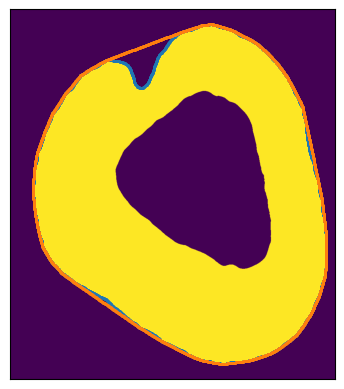

In [9]:
print(f'surface = {len_surf:.1f} --- convex = {len_hull:.1f}')
print(f'GI = {len_surf/len_hull:.3f}')

plt.imshow(donut)

plt.scatter(*get_edge_coords(tissue)[::-1], s=1)
plt.scatter(*get_edge_coords(hull_mask)[::-1], s=1)

plt.xticks([]);
plt.yticks([]);

In [11]:
gyr_index(donut)

(1.0447311805831965, 3387.4410511584783, 3242.4044712320347)